# **Association between Abstract Characteristics and Ranking Position in Technology-Assisted Reviewing (TAR): coding set-up**

### **by Isa Spiero <br>**

#### **Part I: Data**

#### **Part II: Ranking** 

#### **Part III: Evaluation**
------------------------------------------------------------------------------------------------------------------------------------------

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

#### **Part I: Dataprocessing**
Load the data that were preprocessed with the data_preprocessing.ipynb notebook:

In [6]:
df1 = pd.read_csv("./data/processed/Prog_reporting.csv")
#df2 = pd.read_csv("./data/processed/Prog_tripod.csv")

#### **Part II: Ranking**

In [131]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from transformers import AutoModel, AutoTokenizer
from sentence_transformers import SentenceTransformer
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BertModel

os.environ["TRANSFORMERS_CACHE"] = "./models/transformers/cache/"

class ComputeRankings:
    def __init__(self, dataset, feature_extractor, classifier, initial_inclusions=10, initial_exclusions=10,
                 batch_size=10, random_seed=None):
        self.dataset = dataset
        self.feature_extractor = feature_extractor
        self.classifier = classifier
        self.initial_inclusions = initial_inclusions
        self.initial_exclusions = initial_exclusions
        self.batch_size = batch_size
        self.random_seed = random_seed
        self.rng = np.random.default_rng(self.random_seed)

        if 'abstract' not in self.dataset.columns or 'label_ta_included' not in self.dataset.columns:
            raise ValueError("Dataset must have 'abstract' and 'label_ta_included' columns.")

        # Initialize data storage
        self.original_order = list(self.dataset.index)
        self.final_order = []
        self.training_data = None
        self.training_labels = None
        self.remaining_data = None

    def initialize_training_data(self):
        """Randomly selects initial inclusions and exclusions for training."""
        available_inclusions = self.dataset[self.dataset['label_ta_included'] == 1]
        available_exclusions = self.dataset[self.dataset['label_ta_included'] == 0]

        if len(available_inclusions) < self.initial_inclusions or len(available_exclusions) < self.initial_exclusions:
            raise ValueError("Not enough inclusions or exclusions in the dataset.")

        inclusions = available_inclusions.sample(n=self.initial_inclusions, random_state=self.random_seed)
        exclusions = available_exclusions.sample(n=self.initial_exclusions, random_state=self.random_seed)

        self.training_data = pd.concat([inclusions, exclusions])
        self.training_labels = self.training_data['label_ta_included']

        # Store remaining records
        self.remaining_data = self.dataset.drop(self.training_data.index)
        self.final_order = self.training_data.index.tolist()

    def preprocess(self):
        """Converts text abstracts into features based on the feature extractor."""
        self.training_data['abstract'] = self.training_data['abstract'].fillna('NA').astype(str)
        self.remaining_data['abstract'] = self.remaining_data['abstract'].fillna('NA').astype(str)

        # Initialize X_train and X_remaining in case no condition matches
        X_train, X_remaining = None, None

        # Print feature extractor type to debug
        print(f"Feature Extractor Type: {type(self.feature_extractor)}")  # Debugging line

        # Handle the feature extractor types
        if isinstance(self.feature_extractor, TfidfVectorizer):
            print("Using TfidfVectorizer")  # Debugging line
            X_train = self.feature_extractor.fit_transform(self.training_data['abstract'])
            X_remaining = self.feature_extractor.transform(self.remaining_data['abstract'])

        elif isinstance(self.feature_extractor, SentenceTransformer):
            print("Using SentenceTransformer")  # Debugging line
            X_train = np.array(self.feature_extractor.encode(self.training_data['abstract'].tolist()))
            X_remaining = np.array(self.feature_extractor.encode(self.remaining_data['abstract'].tolist()))

        elif isinstance(self.feature_extractor, BertModel):  # Check specifically for BertModel
            print("Using BERT Model")  # Debugging line
            X_train = self._get_huggingface_embeddings(self.training_data['abstract'])
            X_remaining = self._get_huggingface_embeddings(self.remaining_data['abstract'])

        elif isinstance(self.feature_extractor, AutoModel):  # For other Hugging Face models
            print("Using Hugging Face Model (AutoModel)")  # Debugging line
            X_train = self._get_huggingface_embeddings(self.training_data['abstract'])
            X_remaining = self._get_huggingface_embeddings(self.remaining_data['abstract'])

        else:
            # If no known feature extractor is passed, raise an error
            raise ValueError(f"Feature extractor type '{type(self.feature_extractor)}' is not recognized.")

        # If no valid extractor was found, raise an error
        if X_train is None or X_remaining is None:
            raise ValueError("Feature extractor type is not recognized or is incorrectly configured.")

        return X_train, X_remaining

    def train_model(self, X_train):
        """Trains the classifier on the training data."""
        self.classifier.fit(X_train, self.training_labels)

    def predict_and_rank(self, X_remaining):
        """Predicts probabilities and sorts remaining data by relevance."""
        probabilities = self.classifier.predict_proba(X_remaining)[:, 1]
        self.remaining_data['probability'] = probabilities
        self.remaining_data = self.remaining_data.sort_values(by='probability', ascending=False)

    def expand_training_data(self):
        """Moves the top-ranked batch of records into training data."""
        batch_size = min(self.batch_size, len(self.remaining_data))
        if batch_size == 0:
            return

        top_data = self.remaining_data.head(batch_size)
        self.training_data = pd.concat([self.training_data, top_data])
        self.training_labels = self.training_data['label_ta_included']
        self.remaining_data = self.remaining_data.iloc[batch_size:]

        new_indices = top_data.index.tolist()
        self.final_order.extend(new_indices)
        
    def iterative_training(self):
        """Runs the active learning loop to iteratively improve rankings."""
        total_remaining = len(self.remaining_data)
        total_iterations = -(-total_remaining // self.batch_size)
    
        # Initialize the progress bar
        with tqdm(total=total_iterations, desc="Screening progress", unit="iteration", ncols=100, leave=True) as pbar:
            for _ in range(total_iterations):

                pbar.update(0)
                
                X_train, X_remaining = self.preprocess()
                self.train_model(X_train)
                self.predict_and_rank(X_remaining)
                self.expand_training_data()
    
                # Update the progress bar
                pbar.update(1)
    
        # Ensure all original indices are in final order (fix missing values issue)
        missing_indices = set(self.original_order) - set(self.final_order)
        self.final_order.extend(missing_indices)

        return self.original_order, self.final_order

    def _get_huggingface_embeddings(self, texts):
        """Generates Hugging Face model embeddings for a given set of texts."""
        tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')  # Example model: BERT
        model = self.feature_extractor  # Hugging Face model passed here

        # Ensure texts is a list of strings
        texts = texts.tolist() if isinstance(texts, pd.Series) else texts

        # Tokenize the texts (ensure the input is in the correct format)
        inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=512)

        with torch.no_grad():
            outputs = model(**inputs)

        embeddings = outputs.last_hidden_state.mean(dim=1)  # Mean pooling
        return embeddings.numpy()

# Example Usage:
if __name__ == "__main__":
    data_path = "./data/processed/"
    output_path = "./output/rankings/"
    os.makedirs(output_path, exist_ok=True)


    def load_dataset(file_path):
        """Loads a dataset from CSV or Excel."""
        if file_path.endswith('.xlsx'):
            return pd.read_excel(file_path)
        elif file_path.endswith('.csv'):
            df = pd.read_csv(file_path)
            df['abstract'] = df['abstract'].fillna('NA').astype(str)
            return df
        return None


    # Loop over all datasets
    for filename in os.listdir(data_path):
        file_path = os.path.join(data_path, filename)
        dataset = load_dataset(file_path)

        if dataset is None:
            continue  

        # Define parameters
        initial_inclusions = 10
        initial_exclusions = 10
        batch_size = 10
        random_seeds = [6] #range(1, 4)

        # Define list of feature extractors to loop over
        feature_extractors = [
            #('huggingface', AutoModel.from_pretrained('bert-base-uncased')),
            #('sentence_transformer', SentenceTransformer('paraphrase-MiniLM-L6-v2')),
            ('tfidf', TfidfVectorizer(stop_words='english', max_features=5000))
        ]

        # Loop over different feature extractors
        for feature_name, feature_extractor in feature_extractors:
            for random_seed in random_seeds:
                compute_rankings = ComputeRankings(
                    dataset,
                    feature_extractor,
                    LogisticRegression(),
                    initial_inclusions=initial_inclusions,
                    initial_exclusions=initial_exclusions,
                    batch_size=batch_size,
                    random_seed=random_seed
                )

                # Run ranking algorithm
                compute_rankings.initialize_training_data()
                original_order, final_order = compute_rankings.iterative_training()

                # Convert ranking outputs to DataFrames
                original_df = pd.DataFrame({'Original_Index': original_order})
                original_df['Original_Label'] = dataset.loc[original_df['Original_Index'], 'label_ta_included'].values

                final_df = pd.DataFrame({'Final_Index': final_order})
                final_df['Final_Label'] = dataset.loc[final_df['Final_Index'], 'label_ta_included'].values

                # Merge original and final rankings
                ranking_output = pd.concat([original_df, final_df], axis=1)

                # Save rankings to CSV
                output_file = f"{output_path}{os.path.splitext(filename)[0]}_rankings_{feature_name}_{random_seed}.csv"
                ranking_output.to_csv(output_file, index=False)


Screening progress:   0%|                                            | 0/247 [00:00<?, ?iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:   1%|▎                                   | 2/247 [00:00<00:53,  4.59iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:   2%|▌                                   | 4/247 [00:00<00:51,  4.72iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:   2%|▊                                   | 6/247 [00:01<00:49,  4.82iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:   3%|█                                   | 7/247 [00:01<00:50,  4.78iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:   3%|█▏                                  | 8/247 [00:01<00:50,  4.75iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:   4%|█▍                                 | 10/247 [00:02<00:50,  4.67iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:   4%|█▌                                 | 11/247 [00:02<00:50,  4.68iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:   5%|█▊                                 | 13/247 [00:02<00:49,  4.71iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:   6%|██▏                                | 15/247 [00:03<00:49,  4.73iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:   7%|██▍                                | 17/247 [00:03<00:48,  4.70iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:   8%|██▋                                | 19/247 [00:04<00:48,  4.73iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:   9%|██▉                                | 21/247 [00:04<00:48,  4.71iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:   9%|███▎                               | 23/247 [00:04<00:47,  4.68iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  10%|███▌                               | 25/247 [00:05<00:47,  4.68iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  11%|███▊                               | 27/247 [00:05<00:46,  4.73iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  12%|████                               | 29/247 [00:06<00:46,  4.67iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  13%|████▍                              | 31/247 [00:06<00:45,  4.74iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  13%|████▋                              | 33/247 [00:07<00:45,  4.75iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  14%|████▉                              | 35/247 [00:07<00:44,  4.75iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  15%|█████▏                             | 37/247 [00:07<00:43,  4.79iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  16%|█████▌                             | 39/247 [00:08<00:43,  4.78iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  17%|█████▊                             | 41/247 [00:08<00:43,  4.77iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  17%|█████▉                             | 42/247 [00:08<00:42,  4.77iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  18%|██████▏                            | 44/247 [00:09<00:42,  4.78iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  19%|██████▌                            | 46/247 [00:09<00:42,  4.78iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  19%|██████▊                            | 48/247 [00:10<00:41,  4.80iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  20%|██████▉                            | 49/247 [00:10<00:41,  4.80iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  21%|███████▏                           | 51/247 [00:10<00:40,  4.78iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  21%|███████▌                           | 53/247 [00:11<00:41,  4.69iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  22%|███████▊                           | 55/247 [00:11<00:41,  4.62iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  23%|████████                           | 57/247 [00:12<00:40,  4.70iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  24%|████████▎                          | 59/247 [00:12<00:39,  4.75iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  25%|████████▋                          | 61/247 [00:12<00:38,  4.77iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  26%|████████▉                          | 63/247 [00:13<00:38,  4.79iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  26%|█████████▏                         | 65/247 [00:13<00:37,  4.79iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  27%|█████████▍                         | 67/247 [00:14<00:37,  4.82iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  28%|█████████▊                         | 69/247 [00:14<00:37,  4.81iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  29%|██████████                         | 71/247 [00:14<00:36,  4.78iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  30%|██████████▎                        | 73/247 [00:15<00:36,  4.74iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  30%|██████████▋                        | 75/247 [00:15<00:36,  4.72iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  31%|██████████▉                        | 77/247 [00:16<00:36,  4.71iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  32%|███████████                        | 78/247 [00:16<00:35,  4.71iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  32%|███████████▎                       | 80/247 [00:16<00:35,  4.70iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  33%|███████████▌                       | 82/247 [00:17<00:35,  4.69iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  34%|███████████▉                       | 84/247 [00:17<00:34,  4.67iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  35%|████████████▏                      | 86/247 [00:18<00:34,  4.69iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  36%|████████████▍                      | 88/247 [00:18<00:33,  4.69iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  36%|████████████▊                      | 90/247 [00:19<00:33,  4.68iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  37%|█████████████                      | 92/247 [00:19<00:33,  4.68iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  38%|█████████████▎                     | 94/247 [00:19<00:32,  4.65iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  39%|█████████████▌                     | 96/247 [00:20<00:32,  4.64iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  40%|█████████████▉                     | 98/247 [00:20<00:32,  4.61iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  40%|██████████████                     | 99/247 [00:20<00:32,  4.59iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  40%|█████████████▊                    | 100/247 [00:21<00:32,  4.57iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  41%|██████████████                    | 102/247 [00:21<00:31,  4.59iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  42%|██████████████▎                   | 104/247 [00:22<00:31,  4.56iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  43%|██████████████▌                   | 106/247 [00:22<00:30,  4.60iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  44%|██████████████▊                   | 108/247 [00:22<00:30,  4.53iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  45%|███████████████▏                  | 110/247 [00:23<00:30,  4.54iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  45%|███████████████▎                  | 111/247 [00:23<00:29,  4.60iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  46%|███████████████▌                  | 113/247 [00:24<00:28,  4.63iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  47%|███████████████▊                  | 115/247 [00:24<00:28,  4.65iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  47%|████████████████                  | 117/247 [00:24<00:27,  4.67iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  48%|████████████████▍                 | 119/247 [00:25<00:27,  4.65iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  49%|████████████████▋                 | 121/247 [00:25<00:27,  4.66iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  50%|████████████████▉                 | 123/247 [00:26<00:26,  4.67iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  51%|█████████████████▏                | 125/247 [00:26<00:26,  4.65iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  51%|█████████████████▍                | 127/247 [00:27<00:26,  4.60iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  52%|█████████████████▌                | 128/247 [00:27<00:26,  4.54iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  53%|█████████████████▉                | 130/247 [00:27<00:25,  4.55iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  53%|██████████████████▏               | 132/247 [00:28<00:24,  4.62iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  54%|██████████████████▍               | 134/247 [00:28<00:24,  4.65iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  55%|██████████████████▋               | 136/247 [00:28<00:23,  4.66iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  56%|██████████████████▉               | 138/247 [00:29<00:23,  4.67iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  57%|███████████████████▎              | 140/247 [00:29<00:22,  4.67iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  57%|███████████████████▌              | 142/247 [00:30<00:22,  4.68iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  58%|███████████████████▊              | 144/247 [00:30<00:21,  4.69iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  59%|███████████████████▉              | 145/247 [00:30<00:22,  4.62iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  60%|████████████████████▏             | 147/247 [00:31<00:21,  4.63iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  60%|████████████████████▎             | 148/247 [00:31<00:21,  4.63iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  61%|████████████████████▋             | 150/247 [00:32<00:20,  4.63iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  62%|████████████████████▉             | 152/247 [00:32<00:20,  4.62iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  62%|█████████████████████             | 153/247 [00:32<00:25,  3.63iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  63%|█████████████████████▎            | 155/247 [00:33<00:24,  3.77iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  64%|█████████████████████▌            | 157/247 [00:33<00:22,  3.95iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  64%|█████████████████████▉            | 159/247 [00:34<00:21,  4.17iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  65%|██████████████████████▏           | 161/247 [00:34<00:19,  4.33iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  66%|██████████████████████▎           | 162/247 [00:34<00:19,  4.40iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  66%|██████████████████████▍           | 163/247 [00:35<00:18,  4.44iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  67%|██████████████████████▋           | 165/247 [00:35<00:18,  4.54iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  68%|██████████████████████▉           | 167/247 [00:36<00:17,  4.54iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  68%|███████████████████████▏          | 168/247 [00:36<00:17,  4.55iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  69%|███████████████████████▍          | 170/247 [00:36<00:16,  4.61iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  70%|███████████████████████▋          | 172/247 [00:37<00:16,  4.61iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  70%|███████████████████████▊          | 173/247 [00:37<00:16,  4.61iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  71%|████████████████████████          | 175/247 [00:37<00:16,  4.40iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  72%|████████████████████████▎         | 177/247 [00:38<00:15,  4.51iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  72%|████████████████████████▋         | 179/247 [00:38<00:14,  4.56iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  73%|████████████████████████▉         | 181/247 [00:39<00:14,  4.56iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  74%|█████████████████████████▏        | 183/247 [00:39<00:13,  4.57iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  75%|█████████████████████████▍        | 185/247 [00:40<00:13,  4.59iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  76%|█████████████████████████▋        | 187/247 [00:40<00:13,  4.59iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  77%|██████████████████████████        | 189/247 [00:40<00:12,  4.58iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  77%|██████████████████████████▎       | 191/247 [00:41<00:12,  4.56iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  78%|██████████████████████████▌       | 193/247 [00:41<00:11,  4.59iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  79%|██████████████████████████▊       | 195/247 [00:42<00:11,  4.59iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  80%|███████████████████████████       | 197/247 [00:42<00:10,  4.59iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  81%|███████████████████████████▍      | 199/247 [00:43<00:10,  4.52iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  81%|███████████████████████████▌      | 200/247 [00:43<00:10,  4.48iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  82%|███████████████████████████▊      | 202/247 [00:43<00:10,  4.30iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  83%|████████████████████████████      | 204/247 [00:44<00:09,  4.37iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  83%|████████████████████████████▎     | 206/247 [00:44<00:09,  4.47iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  84%|████████████████████████████▋     | 208/247 [00:45<00:08,  4.52iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  85%|████████████████████████████▉     | 210/247 [00:45<00:08,  4.51iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  86%|█████████████████████████████▏    | 212/247 [00:46<00:07,  4.51iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  87%|█████████████████████████████▍    | 214/247 [00:46<00:07,  4.54iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  87%|█████████████████████████████▋    | 216/247 [00:46<00:06,  4.54iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  88%|██████████████████████████████    | 218/247 [00:47<00:06,  4.56iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  89%|██████████████████████████████▎   | 220/247 [00:47<00:05,  4.57iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  90%|██████████████████████████████▌   | 222/247 [00:48<00:05,  4.43iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  91%|██████████████████████████████▊   | 224/247 [00:48<00:05,  4.51iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  91%|███████████████████████████████   | 226/247 [00:49<00:04,  4.54iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  92%|███████████████████████████████▍  | 228/247 [00:49<00:04,  4.56iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  93%|███████████████████████████████▋  | 230/247 [00:49<00:03,  4.57iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  94%|███████████████████████████████▉  | 232/247 [00:50<00:03,  4.55iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  95%|████████████████████████████████▏ | 234/247 [00:50<00:02,  4.57iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  96%|████████████████████████████████▍ | 236/247 [00:51<00:02,  4.55iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  96%|████████████████████████████████▊ | 238/247 [00:51<00:01,  4.54iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  97%|█████████████████████████████████ | 240/247 [00:52<00:01,  4.57iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  98%|█████████████████████████████████▎| 242/247 [00:52<00:01,  4.56iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  98%|█████████████████████████████████▍| 243/247 [00:52<00:00,  4.55iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress:  99%|█████████████████████████████████▋| 245/247 [00:53<00:00,  4.50iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer
Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


Screening progress: 100%|██████████████████████████████████| 247/247 [00:53<00:00,  4.60iteration/s]

Feature Extractor Type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Using TfidfVectorizer


In [108]:
import pandas as pd

# Load the original dataframe
df = df1.copy().reset_index()
print(df.columns)
# List of ranking files
ranking_path = "./output/rankings/"
ranking_files = [
    "Prog_reporting_rankings_tfidf_1.csv",
    "Prog_reporting_rankings_tfidf_2.csv",
    "Prog_reporting_rankings_tfidf_3.csv",
    "Prog_reporting_rankings_tfidf_4.csv",
    "Prog_reporting_rankings_tfidf_5.csv",
    "Prog_reporting_rankings_tfidf_6.csv"
]

# Process each ranking file and merge rankings into separate columns
for file in ranking_files:
    ranking_df = pd.read_csv(ranking_path+file)
    
    # Merge the ranking data with df based on Final_Index
    df = df.merge(ranking_df[['Final_Index', 'Original_Index']], 
                  left_on='index', right_on='Final_Index', 
                  how='left')

    # Rename the ranking column for clarity
    df.rename(columns={'Original_Index': file}, inplace=True)
    
    # Drop 'Final_Index' column after merge to keep the DataFrame clean
    df.drop(columns=['Final_Index'], inplace=True)

# Calculate the average ranking across Ranking_1, Ranking_2, and Ranking_3
df['Ranking_Avg'] = df[ranking_files].mean(axis=1)
df

Index(['index', 'Unnamed: 0', 'type', 'authors', 'year', 'title', 'journal',
       'pmid', 'keywords', 'abstract', 'label_ta_included', 'article_id',
       'label_ft_included', '1i', '1ii', '1iii', '1iv', '2i', '2ii', '2iii',
       '2iv', '2v', '2vi', '2vii', '2viii', '2ix', '2x', '2xi', '2xii',
       'word_count', 'avg_sentence_length', 'structured', 'tfidf_mean',
       'tfidf_deviation'],
      dtype='object')


,index,Unnamed: 0,type,authors,year,title,journal,pmid,keywords,abstract,...,structured,tfidf_mean,tfidf_deviation,Prog_reporting_rankings_tfidf_1.csv,Prog_reporting_rankings_tfidf_2.csv,Prog_reporting_rankings_tfidf_3.csv,Prog_reporting_rankings_tfidf_4.csv,Prog_reporting_rankings_tfidf_5.csv,Prog_reporting_rankings_tfidf_6.csv,Ranking_Avg
0,0,2278,JOUR,"['Csato V', 'Kadir SZSA', 'Khavandi K', 'Benne...",2019.0,"""A Step and a Ceiling"": mechanical properties ...",NaN,NaN,"['eppi-reviewer4', 'Ca2+ spark', 'oxidant sign...",We investigated the biomechanical relationship...,...,0,0.000302,-0.000028,1664,1664,1651,1653,1639,1656,1654.500000
1,1,1242,JOUR,NaN,2019.0,"""Implications of emotion regulation strategies...",NaN,NaN,['eppi-reviewer4'],"Reports an error in ""Implications of emotion r...",...,0,0.000360,0.000030,1857,1860,1865,1853,1855,1860,1858.333333
2,2,1632,JOUR,"['Moyano J', 'Mases L', 'Izeta T', 'Flores T',...",2019.0,"""In Vitro"" Study About Variables that Influenc...",NaN,NaN,"['eppi-reviewer4', 'conventional brackets', 'f...",Many advantages have been described surroundin...,...,0,0.000311,-0.000019,1365,1366,1353,1385,1400,1358,1371.166667
3,3,187,JOUR,"['Song J', 'Han K', 'Lee D', 'Kim SW']",2018.0,"""Is a picture really worth a thousand words?"":...",NaN,NaN,"['eppi-reviewer4', 'Adolescent', 'Age Factors'...",Because using social media has become a major ...,...,0,0.000327,-0.000003,1648,1639,1632,1633,1644,1629,1637.500000
4,4,2406,JOUR,"['Rodrigues MAV', 'Olmos RD', 'Kira CM', 'Lotu...",2019.0,"""Shadow"" OSCE examiner. A cross-sectional stud...",NaN,NaN,['eppi-reviewer4'],OBJECTIVES: Feedback is a powerful learning to...,...,1,0.000286,-0.000044,1883,1869,1866,1862,1864,1870,1869.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2477,2477,24,JOUR,"['Bronsert M', 'Singh AB', 'Henderson WG', 'Ha...",2019.0,Identification of postoperative complications ...,NaN,NaN,"['eppi-reviewer4', 'Elastic-net', 'Machine lea...",BACKGROUND: Using the American College of Surg...,...,1,0.000328,-0.000002,80,127,70,9,70,67,70.500000
2478,2478,2286,JOUR,"['Eill A', 'Jahedi A', 'Gao Y', 'Kohli JS', 'F...",2019.0,Functional Connectivities Are More Informative...,NaN,NaN,"['eppi-reviewer4', '*MRI', '*autism', '*diagno...",Machine learning techniques have been implemen...,...,0,0.000355,0.000025,634,716,676,3,668,654,558.500000
2479,2479,1035,JOUR,"['Cook F', 'Lobo D', 'Martin M', 'Imbert N', '...",2019.0,Prospective validation of a new airway managem...,NaN,NaN,"['eppi-reviewer4', 'Adult', 'Aged', 'Airway Ma...",BACKGROUND: Some patients have features that i...,...,1,0.000319,-0.000011,2,477,367,385,448,468,357.833333
2480,2480,297,JOUR,"['Eggleston B', 'Dismuke-Greer CE', 'Pogoda TK...",2019.0,A prediction model of military combat and trai...,NaN,NaN,"['eppi-reviewer4', 'Prediction', 'concussion a...",Background: Research has shown that number of ...,...,1,0.000300,-0.000030,948,964,944,961,949,974,956.666667


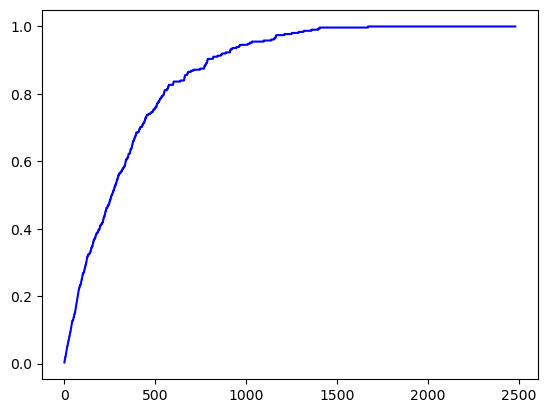

In [98]:
df_sort = df.sort_values(by='Ranking_Avg', ascending=True) 
labels = df_sort['label_ta_included']
 
labels_series = pd.Series(labels)
total_ones = labels_series.sum()
cumulative_sum = labels_series.cumsum()
proportion_ones = cumulative_sum / total_ones
proportion_ones
plt.plot(range(0, len(df)), proportion_ones, label='Line plot', color='blue') 

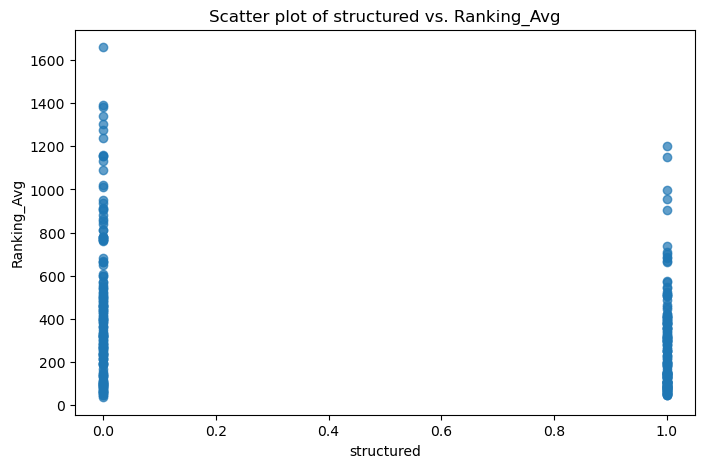

In [129]:
import matplotlib.pyplot as plt

df = df[df['label_ta_included'] == 1].copy()

# Choose a variable for the y-axis (replace 'Some_Column' with your actual column name)
y_variable = 'structured'  

# Create the scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(df[y_variable], df['Ranking_Avg'], alpha=0.7)

# Add labels and title
plt.ylabel("Ranking_Avg")
plt.xlabel(y_variable)
plt.title(f"Scatter plot of {y_variable} vs. Ranking_Avg")

# Show the plot
plt.show()


#### **Part II: Applying stopping methods**

Stopping after encountering x consecutive irrelevant records

In [ ]:
import pandas as pd

class StoppingAfterConsecutiveIrrelevant:
    def __init__(self):
        """
        Initializes the termination condition. Does not require `hyperparameter `
        during initialization.
        """
        self.hyperparameter = None

    def set_hyperparameter (self, hyperparameter ):
        """
        Sets the hyperparameter after object initialization.

        :param hyperparameter : The number of consecutive observations with label 0 
                                  that will trigger early termination.
        """
        self.hyperparameter  = hyperparameter 

    def __hash__(self):
        return hash('StoppingAfterConsecutiveIrrelevant')  

    def __eq__(self, other):
        return isinstance(other, StoppingAfterConsecutiveIrrelevant)

    def evaluate_ranking(self, rankings_df):
        """
        Evaluates when the stopping condition is met and computes recall based on rankings.
        
        :param rankings_df: A pandas DataFrame containing the columns:
                            'Original_Index', 'Original_Label', 'Final_Index', 'Final_Label'
        :return: A dictionary containing termination point, TP, FP, FN, TN, and recall.
        """
        if self.hyperparameter  is None:
            raise ValueError("hyperparameter must be set before evaluating rankings")

        consecutive_zeros = 0
        termination_point = None

        # Iterate through the Final_Label column to find the termination point
        for i, label in enumerate(rankings_df['Final_Label']):
            if label == 0:
                consecutive_zeros += 1
            else:
                consecutive_zeros = 0  
            
            if consecutive_zeros == self.hyperparameter :
                termination_point = i + 1 
                break

        # If the condition is never met, recall should be 1
        if termination_point is None:
            TP = rankings_df['Final_Label'].sum()  
            TN = (rankings_df['Final_Label'] == 0).sum() 
            termination_target = len(list(rankings_df['Final_Label'])) - 1 - list(rankings_df['Final_Label'])[::-1].index(1)
            return {
                "Termination_Point": len(rankings_df),
                "Termination_Target": termination_target,
                "TP": TP,
                "FP": 0,
                "FN": 0,
                "TN": TN,
                "Recall": 1.0
            }
        else:
            # Compute TP, FP, FN, and TN based on termination point
            TP = rankings_df['Final_Label'][:termination_point].sum()
            FP = (rankings_df['Final_Label'][:termination_point] == 0).sum()
            FN = rankings_df['Final_Label'][termination_point:].sum()
            TN = (rankings_df['Final_Label'][termination_point:] == 0).sum()
    
            # Compute recall
            recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    
            # Retrieve the ideal termination point
            termination_target = len(list(rankings_df['Final_Label'])) - 1 - list(rankings_df['Final_Label'])[::-1].index(1)
            
            return {
                "Termination_Point": termination_point,
                "Termination_Target": termination_target,
                "TP": TP,
                "FP": FP,
                "FN": FN,
                "TN": TN,
                "Recall": recall,
                "Ranking_df": rankings_df
            }

# Example
if __name__ == "__main__":
    rankings_df = pd.read_csv('../../output/rankings/Int_CD005139_rankings_1.csv') 
    evaluator = StoppingAfterConsecutiveIrrelevant()  
    evaluator.set_hyperparameter(50) 
    result = evaluator.evaluate_ranking(rankings_df)

    print(result)

Stopping after having screened a percentage of x records

In [ ]:
import pandas as pd

class StoppingAfterPercentage:
    def __init__(self):
        """
        Initializes the termination condition based on percentage.
        Does not require `hyperparameter` during initialization.
        """
        self.hyperparameter = None 
        self.termination_point = None

    def set_hyperparameter(self, hyperparameter):
        """
        Sets the hyperparameter after object initialization.

        :param hyperparameter: The percentage of the total rows to process before terminating.
        """
        self.hyperparameter = hyperparameter

    def __hash__(self):
        return hash('StoppingAfterPercentage')

    def __eq__(self, other):
        return isinstance(other, StoppingAfterPercentage)
        
    def evaluate_ranking(self, rankings_df):
        """
        Evaluates the rankings and calculates the termination point based on hyperparameter.
        
        :param rankings_df: DataFrame containing 'Original_Index', 'Original_Label', 'Final_Index', 'Final_Label'.
        :return: Dictionary with the evaluation metrics, or None if termination condition is not met.
        """
        if self.hyperparameter is None:
            raise ValueError("hyperparameter must be set before evaluating rankings")

        total_rows = len(rankings_df)
        rows_to_process = int(self.hyperparameter * total_rows / 100)
        self.termination_point = rows_to_process

        return self.calculate_metrics(rankings_df)
    
    def calculate_metrics(self, rankings_df, all_processed=False):
        """
        Calculate TP, FP, FN, TN and recall based on the termination point.
        
        :param rankings_df: DataFrame containing the ranking results.
        :param all_processed: Flag to indicate if we are considering all data without termination.
        :return: Dictionary with the evaluation metrics.
        """

        if not all_processed:
            termination_point = self.termination_point
            TP = rankings_df['Final_Label'][:termination_point].sum()
            FP = (rankings_df['Final_Label'][:termination_point] == 0).sum()
            FN = rankings_df['Final_Label'][termination_point:].sum()
            TN = (rankings_df['Final_Label'][termination_point:] == 0).sum()

        recall = TP / (TP + FN) if TP + FN > 0 else 0

        # Retrieve the ideal termination point
        termination_target = len(list(rankings_df['Final_Label'])) - 1 - list(rankings_df['Final_Label'])[::-1].index(1)

        return {
            "Termination_Point": self.termination_point,
            "Termination_Target": termination_target,
            "TP": TP,
            "FP": FP,
            "FN": FN,
            "TN": TN,
            "Recall": recall,
            "Ranking_df": rankings_df
        }

# Example        
if __name__ == "__main__":
    rankings_df = pd.read_csv('../../output/rankings/Int_CD005139_rankings_1.csv') 
    evaluator = StoppingAfterPercentage() 
    evaluator.set_hyperparameter(80)
    result = evaluator.evaluate_ranking(rankings_df)

    print(result)

Choose the stopping methods and set the hyperparameter values. Loop over all combinations for all datasets

In [ ]:
import os
data_path = "../../output/rankings/"

methods_dict = {
    StoppingAfterPercentage(): [10, 20, 30],
    StoppingAfterConsecutiveIrrelevant(): [25, 50, 100, 200, 400, 800, 1600]
}

all_results = {}
for key,values in methods_dict.items():
    method = key.__class__.__name__  
    all_results[method] = {}
    
    for filename in os.listdir(data_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(data_path, filename)               
            rankings_df = pd.read_csv(file_path)  
            df_name = str(os.path.splitext(filename)[0])
            all_results[method][df_name] = {} 
 
            for hyperparameter in values:
                hyperparameter = int(hyperparameter)
                evaluator = key
                evaluator.set_hyperparameter(hyperparameter) 
                result = evaluator.evaluate_ranking(rankings_df)
                all_results[method][df_name][hyperparameter]=result
                
#print(all_results)

#### **Part III: Evaluation**

Convert the results into tabular format for further evaluation and presenting of the results

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats

# Construct DataFrame from nested dictionary
table_rows = [
    {
        'Method': method,
        'Dataset': '_'.join(dataset.split('_')[:-1]),
        'Rankings': dataset,
        'Seed': dataset.split('_')[-1],
        'Hyperparameter': hyperparam,
        'Termination_Point': metrics.get('Termination_Point'),
        'Termination_Target': metrics.get('Termination_Target'),
        'TP': metrics.get('TP'),
        'FP': metrics.get('FP'),
        'FN': metrics.get('FN'),
        'TN': metrics.get('TN'),
        'Recall': metrics.get('Recall'),
        'Ranking_df': metrics.get('Ranking_df')
    }
    for method, datasets in all_results.items()
    for dataset, hyperparameters in datasets.items()
    for hyperparam, metrics in hyperparameters.items()
]

raw_results = pd.DataFrame(table_rows)
raw_results[['Hyperparameter', 'Seed']] = raw_results[['Hyperparameter', 'Seed']].apply(pd.to_numeric, errors='coerce')
evaluation_results = raw_results.sort_values(by=['Method', 'Hyperparameter', 'Dataset', 'Seed'])

Visualize per dataset and stopping method the target recall and achieved recall per hyperparameter

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Create a PDF file to store all plots
with PdfPages("../../results/figures/results_plots.pdf") as pdf:
    for method, datasets in all_results.items():
        method_name = method
        
        for ranking, results in all_results[method].items():
            rankings_name = ranking

            method_and_dataset = evaluation_results[
                (evaluation_results['Method'] == method_name) & 
                (evaluation_results['Rankings'] == rankings_name)
            ]
            termination_limits = list(method_and_dataset['Termination_Point'])
            termination_target = list(method_and_dataset['Termination_Target'])[0]
            hyperparameters = list(method_and_dataset['Hyperparameter'])
            dataset_name = list(method_and_dataset['Dataset'])[0]  
            labels = method_and_dataset['Ranking_df'].iloc[0]['Final_Label']
             
            labels_series = pd.Series(labels)
            total_ones = labels_series.sum()
            cumulative_sum = labels_series.cumsum()
            proportion_ones = cumulative_sum / total_ones
            
            fig, ax = plt.subplots(figsize=(10, 7))  
            ax.plot(np.arange(1, len(labels) + 1), proportion_ones, color='blue')
            ax.set_xlabel("Number of records screened")
            ax.set_ylabel("Recall")
            
            for i in range(len(termination_limits)):
                stopping_point = termination_limits[i] - 1  # Adjust for zero-based indexing
                hyperparameter = hyperparameters[i]
                ax.axvline(x=stopping_point, color='r', linestyle='--')
                target_met = round(proportion_ones[stopping_point] - 0.95, 2)
                ax.text(stopping_point, 1.07, str(target_met), fontsize=5, ha='center')
                ax.text(stopping_point, 1.1, str(hyperparameter), fontsize=6, ha='center')
                
            ax.axvline(termination_target, color='g', linestyle='-')
            ax.grid(True)
            
            # Set the plot title and move it below the plot
            title = f"{method_name} | {rankings_name}"
            ax.set_title(title, fontsize=8, pad=25)  
            fig.subplots_adjust(bottom=0.2)  

            # Save the current figure to the PDF
            pdf.savefig(fig)
            plt.show(fig)
            plt.close(fig)

print("All plots saved to results_plots.pdf")


#### **Part IV: Aggregation and conclusion**

Visualize for each stopping method the achieved recalls per dataset, with the colors corresponding to the hyperparameters that was used for the simulation. This enables users to see: (1) which stopping methods generally reach the target recall, (2) which hyperparameters for an individual stopping method generally reach the target recall, (3) the variation of hyperparameter performance (i.e. spread of the data points with the same color), and (4) the worst case scenario (i.e. the lowest dot for a given stopping method/hyperparameter). 

In [ ]:
with PdfPages("../../results/figures/plots_individual_methods.pdf") as pdf:
    plt.figure(figsize=(10, 6))
    g = sns.FacetGrid(evaluation_results, col='Method', height=5, aspect=1)
    g.map(sns.stripplot, 'Dataset', 'Recall', jitter=True)
    g.map_dataframe(sns.stripplot, x='Dataset', y='Recall', hue='Hyperparameter', jitter=True, palette='tab10')
    g.map(lambda **kwargs: plt.axhline(0.95, color='black', linestyle='--'))
    g.set_xticklabels(rotation=90)
    g.set_axis_labels('Dataset', 'Recall')
    g.set_titles("{col_name}")


    for ax in g.axes.flat:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, title='Hyperparameter', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()

    pdf.savefig(g.fig)
    plt.show(g.fig)
    plt.close(g.fig)

print("All plots saved to plot_individual_methods.pdf")

In [ ]:
# Function to compute overshooting, undershooting, and recall statistics
def calculate_overshooting_undershooting(recalls, target):
    overshooting = recalls[recalls > target] - target  
    undershooting = target - recalls[recalls < target]  
    exact_match = recalls[recalls == target]  
    
    return pd.Series({
        'count_undershooting': undershooting.count(),
        'count_exact': exact_match.count(),
        'count_overshooting': overshooting.count(),
        'avg_undershooting': -undershooting.mean() if not undershooting.empty else 0,
        'std_undershooting': undershooting.std() if not undershooting.empty else 0,
        'avg_overshooting': overshooting.mean() if not overshooting.empty else 0,
        'std_overshooting': overshooting.std() if not overshooting.empty else 0,
        'mean_recalls': recalls.mean(),
        'confidence_interval_lower': stats.norm.interval(0.95, loc=recalls.mean(), scale=recalls.std()/np.sqrt(len(recalls)))[0],
        'confidence_interval_upper': stats.norm.interval(0.95, loc=recalls.mean(), scale=recalls.std()/np.sqrt(len(recalls)))[1]
    })

# Compute overshooting/undershooting statistics
target_value = 0.95
result_df = (
    evaluation_results.groupby(['Dataset', 'Method', 'Hyperparameter'])['Recall']
    .apply(lambda x: calculate_overshooting_undershooting(x, target_value))
    .reset_index()
)

# Pivot results
pivot_result = result_df.pivot(index=['Dataset', 'Method', 'Hyperparameter'], columns='level_3')
pivot_result.columns = pivot_result.columns.droplevel(0)
pivot_result.reset_index(inplace=True)

# Find lowest positive avg_overshooting per (Dataset, Method)
filtered_df = pivot_result[pivot_result['avg_overshooting'] > 0]
min_overshooting_df = filtered_df.loc[filtered_df.groupby(['Dataset', 'Method'])['avg_overshooting'].idxmin()]

# Get most frequent Hyperparameter for each Method (handling ties)
selected_hyperparameters = (
    min_overshooting_df.groupby('Method')['Hyperparameter']
    .agg(lambda x: ', '.join(map(str, x.mode())))
    .reset_index()
)

selected_hyperparameters.to_csv("../../results/tables/selected_hyperparameters.csv", index=False)

selected_hyperparameters